Tubulin Workflow for static images.

In [1]:
# STEP 1: IMPORT PACKAGES

import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.vessel import filament_3d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, edge_preserving_smoothing_3d, image_smoothing_gaussian_3d
from skimage.morphology import remove_small_objects  

import pandas as pd
from tifffile import imsave

In [2]:
# STEP 2: READ IN INPUT FILE 

filename = r"\\allen\aics\assay-dev\users\Sandi\aics-segmentation\lookup_table_demo\tubulin\notebooks\0430-ipscm-#5-siqi-wt-1-ctnt488-pcnt568-atub647-dapi-PFActrl-0429staining-a-20x-z.tif"
reader = AICSImage(filename) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


(1, 4, 11, 1024, 1024)


4


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


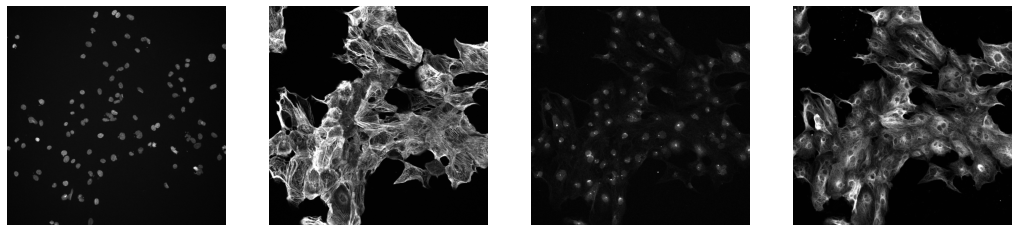

In [18]:
# STEP 3 (OPTIONAL): VIEW INPUT FILE 

N_CHANNELS = IMG.shape[1]
print(N_CHANNELS)

MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS==1:
    ax.axis('off')
    ax.imshow(IMG[0,0,0,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

In [24]:
# STEP 4: SELECT CHANNEL WITH STRUCTURE OF INTEREST

structure_channel = 3

struct_img0 = IMG[0,structure_channel,:,:,:].copy() # this will be your input
view(single_fluorescent_view(struct_img0)) # view the image

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

<h2> PRE-PROCESSING STEPS <h2>

In [25]:
# STEP 5: INTENSITY NORMALIZATION AND SMOOTHING

## PARAMETERS for this step ##
intensity_scaling_param = [0]

# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

# smoothing with edge preserving smoothing 
structure_img_smooth = edge_preserving_smoothing_3d(struct_img)


intensity normalization: min-max normalization with NO absoluteintensity upper bound


In [26]:
# view output if desired 
view(single_fluorescent_view(structure_img_smooth))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

<h2> CORE ALGORITHM STEPS <h2>

In [27]:
# STEP 6: APPLYING 3D FILAMENT FILTER

f3_param = [[1, 0.01]]
bw = filament_3d_wrapper(structure_img_smooth, f3_param)

In [28]:
# view output if desired
viewer_bw =view(segmentation_quick_view(bw))
viewer_bw

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

<h2> POST-PROCESSING STEPS <h2>

In [29]:
# STEP 7: APPLYING SIZE FILTER
minArea = 4
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

In [30]:
# view output if desired
viewer_final = view(segmentation_quick_view(seg))
viewer_final

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [33]:
# save segmentation output!

out=seg.astype(np.uint8)
out[out>0]=255
imsave("segmentation.tiff", out)